In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms

from matplotlib import pyplot as plt
import cv2
import os

# Task I. Data Preparation #

In [2]:
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
# Use label 0-9 representing A-J respectively
class NotmnistDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir='./notMNIST_small', transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_tuples = []      # store (image_name, label)
        for index, letter in enumerate(letters):
            all_images = os.listdir(os.path.join(root_dir, letter))
            self.image_tuples.extend(
                [(image_name, index) for image_name in all_images]
            )
        
    def __getitem__(self, index):
        image_name, label = self.image_tuples[index]
        try:
            img = cv2.imread(filename=os.path.join(self.root_dir, letters[label], image_name))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if self.transform:
                img = self.transform(img)
            return (img, label)
        except Exception as e:
            print(f'{os.path.join(self.root_dir, letters[label], image_name)} is corrupted and removed.')
            os.remove(os.path.join(self.root_dir, letters[label], image_name))

    def __len__(self):
        return len(self.image_tuples)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((.5,), (.5,))
])
dataset = NotmnistDataset(transform=transform)
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [15000, 1000, len(dataset) - 16000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

print(f'set size: training = {len(train_set)}, validation = {len(valid_set)}, test = {len(test_set)}')

set size: training = 15000, validation = 1000, test = 2724


# Task II. Neural Network Training #

In [4]:
class Network(nn.Module):
    def __init__(self, hidden_size=1000):
        super().__init__()
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(28 * 28 * 3, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

In [5]:
# The helper function that returns the accuracy of a model on a dataset
def getModelAccuracy(model, dataloader):
    for images, labels in dataloader:
        model.eval()
        with torch.no_grad():
            images = torch.flatten(images, start_dim=1)
            predict = model(images)
            predict = torch.argmax(predict, dim=1)
            accuracy = (torch.sum(predict == labels).item()) / labels.shape[0]
        return accuracy

In [6]:
# The function that trains a model and return axis for plotting
def train_model(model, optimizer, criterion, epochs):
    train_axis, valid_axis, test_axis, train_loss_axis, valid_loss_axis = [], [], [], [], []
    for e in range(epochs):
        train_loss = 0
        model.train()
        for images, labels in train_loader:
            images = torch.flatten(images, start_dim=1)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss

        model.eval()
        valid_loss = 0
        for images, labels in valid_loader:
            with torch.no_grad():
                images = torch.flatten(images, start_dim=1)
                output = model(images)
                valid_loss += criterion(output, labels)
        train_axis.append(getModelAccuracy(model, train_loader))
        valid_axis.append(getModelAccuracy(model, valid_loader))
        test_axis.append(getModelAccuracy(model, test_loader))
        train_loss_axis.append(train_loss / len(train_set))
        valid_loss_axis.append(valid_loss / len(valid_set))
    return train_axis, valid_axis, test_axis, train_loss_axis, valid_loss_axis

In [7]:
# global hyperparameters
epochs = 20
criterion = nn.CrossEntropyLoss()

In [8]:
# Try different LRs
best_acc, model_1 = 0, None 
train_axis, valid_axis, test_axis, train_loss_axis, valid_loss_axis = [], [], [], [], []
for lr in [0.005, 0.001, 0.05, 0.1, 1]:
    model = Network()
    _1, _2, _3, _4, _5 = train_model(
        model, 
        optimizer=optim.SGD(model.parameters(), lr=lr),
        criterion=criterion, 
        epochs=epochs
    )
    valid_acc = getModelAccuracy(model, valid_loader)
    print(f'Learning Rate = {lr}, Validation Accuracy = {valid_acc}')
    if valid_acc > best_acc:
        best_acc = valid_acc
        model_1 = model
        train_axis, valid_axis, test_axis, train_loss_axis, valid_loss_axis = _1, _2, _3, _4, _5

Learning Rate = 0.005, Validation Accuracy = 0.828125
Learning Rate = 0.001, Validation Accuracy = 0.90625
Learning Rate = 0.05, Validation Accuracy = 0.921875
Learning Rate = 0.1, Validation Accuracy = 0.921875
Learning Rate = 1, Validation Accuracy = 0.875


## According to the above results, we set the learning rate to 0.05 ##

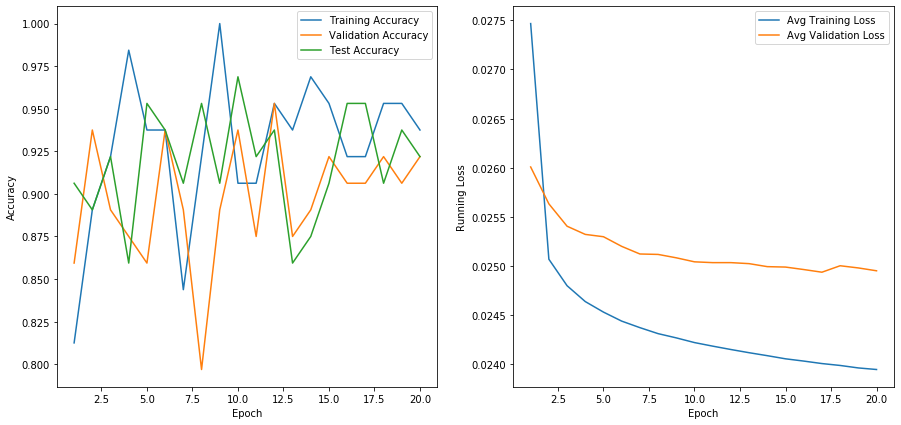

Training Accuracy = 0.9375,     Validation Accuracy= 0.921875,     Test Accuracy = 0.921875


In [10]:
# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
ax1, ax2 = axes.flatten()
ax1.plot(range(1, epochs + 1), train_axis, label='Training Accuracy')
ax1.plot(range(1, epochs + 1), valid_axis, label='Validation Accuracy')
ax1.plot(range(1, epochs + 1), test_axis, label='Test Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax2.plot(range(1, epochs + 1), train_loss_axis, label='Avg Training Loss')
ax2.plot(range(1, epochs + 1), valid_loss_axis, label='Avg Validation Loss')
ax2.set_ylabel('Running Loss')
ax2.set_xlabel('Epoch')
ax2.legend()
plt.show()
print(f'Training Accuracy = {train_axis[-1]}, \
    Validation Accuracy= {valid_axis[-1]}, \
    Test Accuracy = {test_axis[-1]}')

# Task III. Testing the Number of Hidden Units #

In [11]:
model_100 = Network(hidden_size=100)
optimizer = optim.SGD(model_100.parameters(), lr=0.005)
train_model(model_100, optimizer, criterion, epochs)

model_500 = Network(hidden_size=500)
optimizer = optim.SGD(model_500.parameters(), lr=0.005)
train_model(model_500, optimizer, criterion, epochs)

model_1000 = Network(hidden_size=1000)
optimizer = optim.SGD(model_1000.parameters(), lr=0.005)
train_model(model_1000, optimizer, criterion, epochs)

print(f'Validation Accuracy:\n \
    100 hidden units: {getModelAccuracy(model_100, valid_loader)}\n \
    500 hidden units: {getModelAccuracy(model_500, valid_loader)}\n \
    1000 hidden units: {getModelAccuracy(model_1000, valid_loader)}')

Validation Accuracy:
     100 hidden units: 0.828125
     500 hidden units: 0.875
     1000 hidden units: 0.828125


## So we pick the net with 500 hidden units ##

In [12]:
print(f'Final Test Accuracy: {getModelAccuracy(model_500, test_loader)}')

Final Test Accuracy: 0.921875


## Comments: We need a 'just' good amount of units. ##
## Too few hidden units may lead to a higher training error due to underfitting. <br/> ##
## While too many hidden units may cause high generalization error because of overfitting.  ##

# Task IV. Testing the Number of Layers #

In [13]:
class NewNetwork(nn.Module):
    def __init__(self, hidden_size=500):
        super().__init__()
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(28 * 28 * 3, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

In [14]:
model_2_layers = NewNetwork()
optimizer = optim.SGD(model_2_layers.parameters(), lr=0.005)
train_model(model_2_layers, optimizer, criterion, epochs)

print(f'Final Validation Accuracy: {getModelAccuracy(model_2_layers, valid_loader)}')
print(f'Test Accuracy: \n \
    2-layer NN: {getModelAccuracy(model_2_layers, test_loader)} \n \
    1-layer NN: {getModelAccuracy(model_1, test_loader)}')

Final Validation Accuracy: 0.890625
Test Accuracy: 
     2-layer NN: 0.875 
     1-layer NN: 0.875


## These two models gave the same accuracy on the test set. ##

# Part V. Dropout #

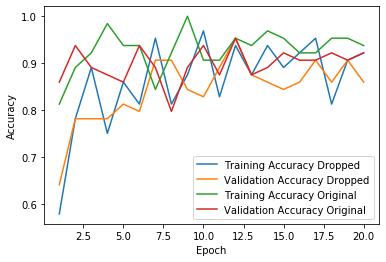

In [15]:
net_dropped = nn.Sequential(
    nn.Linear(28 * 28 * 3, 1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000, 10),
    nn.Softmax(dim=1)
)
optimizer = optim.SGD(net_dropped.parameters(), lr=0.005)

train_axis_dropped, valid_axis_dropped, _1, _2, _3 = train_model(net_dropped, optimizer, criterion, epochs)

plt.plot(range(1, epochs + 1), train_axis_dropped, label='Training Accuracy Dropped')
plt.plot(range(1, epochs + 1), valid_axis_dropped, label='Validation Accuracy Dropped')
plt.plot(range(1, epochs + 1), train_axis, label='Training Accuracy Original')
plt.plot(range(1, epochs + 1), valid_axis, label='Validation Accuracy Original')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
print(f'Final Test Accuracy: \n \
    Dropped: {getModelAccuracy(net_dropped, test_loader)} \n \
    Original: {getModelAccuracy(model_1, test_loader)}')

Final Test Accuracy: 
     Dropped: 0.859375 
     Original: 0.921875


## Comments: ##
## Dropout slightly decreases the accuracy, a possible explanation is it disabled parial neurons during the training process. ##